In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import warnings
import os
import datetime
import tensorflow.keras
warnings.filterwarnings('ignore')
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

amazon = pd.read_csv('/content/drive/MyDrive/D213/amazon_cells_labelled.txt', sep='\t', header=None, names=['input', 'sentiment'], skipinitialspace=True)
imdb = pd.read_csv('/content/drive/MyDrive/D213/imdb_labelled.txt', sep='\t', header=None, names=['input', 'sentiment'], skipinitialspace=True)
yelp = pd.read_csv('/content/drive/MyDrive/D213/yelp_labelled.txt', sep='\t', header=None, names=['input', 'sentiment'], skipinitialspace=True)

df = pd.concat([amazon, imdb, yelp], ignore_index=True)

df.shape, df.head()

((2748, 2),
                                                input  sentiment
 0  So there is no way for me to plug it in here i...          0
 1                        Good case, Excellent value.          1
 2                             Great for the jawbone.          1
 3  Tied to charger for conversations lasting more...          0
 4                                  The mic is great.          1)

In [106]:
df.isnull().sum()

,0
input,0
sentiment,0


In [107]:
df['totalwords'] = [len(x.split()) for x in df['input'].tolist()]
df['total chars'] = df['input'].apply(len)
df.head()

,input,sentiment,totalwords,total chars
0,So there is no way for me to plug it in here i...,0,21,82
1,"Good case, Excellent value.",1,4,27
2,Great for the jawbone.,1,4,22
3,Tied to charger for conversations lasting more...,0,11,79
4,The mic is great.,1,4,17


In [108]:
df['cleaned'] = df['input'].str.lower()
df.head()

,input,sentiment,totalwords,total chars,cleaned
0,So there is no way for me to plug it in here i...,0,21,82,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",1,4,27,"good case, excellent value."
2,Great for the jawbone.,1,4,22,great for the jawbone.
3,Tied to charger for conversations lasting more...,0,11,79,tied to charger for conversations lasting more...
4,The mic is great.,1,4,17,the mic is great.


In [109]:
df['cleaned'] = df['cleaned'].str.replace(r'[^\w\s]|[\d+]|[^\x00-\x7F]', '', regex=True)
df.head()

,input,sentiment,totalwords,total chars,cleaned
0,So there is no way for me to plug it in here i...,0,21,82,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",1,4,27,good case excellent value
2,Great for the jawbone.,1,4,22,great for the jawbone
3,Tied to charger for conversations lasting more...,0,11,79,tied to charger for conversations lasting more...
4,The mic is great.,1,4,17,the mic is great


In [110]:
x = df['cleaned']
print('''\n''', x)

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(x)


 0       so there is no way for me to plug it in here i...
1                               good case excellent value
2                                   great for the jawbone
3       tied to charger for conversations lasting more...
4                                        the mic is great
                              ...                        
2743    i think food should have flavor and texture an...
2744                              appetite instantly gone
2745    overall i was not impressed and would not go back
2746    the whole experience was underwhelming and i t...
2747    then as if i hadnt wasted enough of my life th...
Name: cleaned, Length: 2748, dtype: object


In [111]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

data_set = []
for sentence in df.cleaned:
  data_set.append([word for word in word_tokenize(sentence) if word not in stop_words])

df['cleaned'] = data_set
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,input,sentiment,totalwords,total chars,cleaned
0,So there is no way for me to plug it in here i...,0,21,82,"[way, plug, us, unless, go, converter]"
1,"Good case, Excellent value.",1,4,27,"[good, case, excellent, value]"
2,Great for the jawbone.,1,4,22,"[great, jawbone]"
3,Tied to charger for conversations lasting more...,0,11,79,"[tied, charger, conversations, lasting, minute..."
4,The mic is great.,1,4,17,"[mic, great]"


In [112]:
nltk.download('wordnet')

df['cleaned'] = df['cleaned'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])
df['Lemmed_word_count'] = df['cleaned'].apply(len)
df['Lemmed_char'] = df['cleaned'].apply(lambda words: sum(len(word) for word in words))

df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,input,sentiment,totalwords,total chars,cleaned,Lemmed_word_count,Lemmed_char
0,So there is no way for me to plug it in here i...,0,21,82,"[way, plug, u, unless, go, converter]",6,25
1,"Good case, Excellent value.",1,4,27,"[good, case, excellent, value]",4,22
2,Great for the jawbone.,1,4,22,"[great, jawbone]",2,12
3,Tied to charger for conversations lasting more...,0,11,79,"[tied, charger, conversation, lasting, minutes...",6,49
4,The mic is great.,1,4,17,"[mic, great]",2,8


In [113]:
word_counts = Counter([word for sentence in df["cleaned"] for word in sentence])
vocab_size = len(word_counts)  # Consider all unique words
# or
#vocab_size = len([word for word, count in word_counts.items() if count >= 4])  # Words with frequency >= 5

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 4764


In [114]:
sequences = tokenizer.texts_to_sequences(df.cleaned)
df['sequences'] = sequences
print('''\n''', sequences)


 [[116, 363, 631, 75, 2186], [18, 149, 97, 507], [20, 1052], [2187, 232, 1583, 1054, 2188, 291], [844, 20], [2189, 363, 87, 290, 144, 87, 460, 364], [365, 1433, 365, 2190, 2551, 1056, 427, 845, 33, 33], [723, 2191, 266], [1057, 129, 428, 156], [145, 156, 40], [109, 74, 20], [233, 146, 429, 114, 1434, 114], [133, 2192, 2193, 2194, 366, 1435, 2195, 1058, 2196, 109, 111], [18, 74, 250], [367, 1059, 134, 846, 219], [196, 101, 33, 724, 1436, 28], [847, 313, 2197], [173, 18], [90, 20], [39, 116, 120, 1060, 182, 2199, 56, 251], [220, 1437, 848, 2200, 798, 94, 87, 849], [205, 106, 2202, 1061, 206, 207], [3707, 2204], [398, 850, 159, 114, 133, 486, 279, 399, 277, 314, 726], [205, 1062, 291, 114], [20, 1063, 1064, 28, 1065], [78, 727, 28, 1518, 129, 61, 1438, 28, 78], [119, 112, 2378, 728, 461], [147, 235, 315, 252, 852, 2205, 252, 28], [166, 633, 316], [508, 135, 28, 106, 2206, 2207], [85, 2208, 147, 37, 2209, 134, 2210], [1439, 853, 208, 2211, 1066], [133, 302, 344, 1440, 509, 28], [208, 232,

In [115]:
print(tokenizer.word_index)

{'the': 1, 'and': 2, 'i': 3, 'a': 4, 'is': 5, 'to': 6, 'it': 7, 'this': 8, 'of': 9, 'was': 10, 'in': 11, 'for': 12, 'not': 13, 'that': 14, 'with': 15, 'my': 16, 'very': 17, 'good': 18, 'on': 19, 'great': 20, 'you': 21, 'but': 22, 'have': 23, 'are': 24, 'movie': 25, 'as': 26, 'so': 27, 'phone': 28, 'film': 29, 'its': 30, 'be': 31, 'all': 32, 'one': 33, 'had': 34, 'at': 35, 'food': 36, 'like': 37, 'just': 38, 'place': 39, 'time': 40, 'were': 41, 'service': 42, 'an': 43, 'if': 44, 'from': 45, 'really': 46, 'there': 47, 'bad': 48, 'they': 49, 'we': 50, 'has': 51, 'out': 52, 'well': 53, 'about': 54, 'dont': 55, 'would': 56, 'no': 57, 'or': 58, 'your': 59, 'by': 60, 'best': 61, 'only': 62, 'even': 63, 'ever': 64, 'here': 65, 'also': 66, 'will': 67, 'back': 68, 'up': 69, 'when': 70, 'me': 71, 'more': 72, 'than': 73, 'quality': 74, 'go': 75, 'what': 76, 'love': 77, 'ive': 78, 'he': 79, 'can': 80, 'made': 81, 'which': 82, 'because': 83, 'how': 84, 'product': 85, 'im': 86, 'get': 87, 'too': 88, 

In [116]:
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 5001


In [117]:
total_length = sum(len(seq) for seq in sequences)
average_length = total_length / len(sequences)

print("Average sequence length:", average_length)

Average sequence length: 6.442503639010189


In [118]:
max_length = 10
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating = 'post')
print(padded.shape)
print(padded[0])

(2748, 10)
[ 116  363  631   75 2186    0    0    0    0    0]


In [119]:
padded

array([[ 116,  363,  631, ...,    0,    0,    0],
       [  18,  149,   97, ...,    0,    0,    0],
       [  20, 1052,    0, ...,    0,    0,    0],
       ...,
       [ 284,  233,   56, ...,    0,    0,    0],
       [ 354,  162, 2070, ...,  286,   40,    0],
       [1755,  428,  130, ...,  607,  525,    0]], dtype=int32)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(padded, df['sentiment'], test_size=0.2, random_state=42)

In [121]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

test_df = pd.DataFrame(X_test)
test_df['target'] = y_test

train_data = pd.concat([train_df, y_train], ignore_index=True)
test_data = pd.concat([pd.DataFrame(X_test), y_test], ignore_index=True)

train_data.to_csv('/content/drive/MyDrive/D213/train_data.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/D213/test_data.csv', index=False)

In [122]:
embed_size = 75

In [123]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_shape = (X_train.shape[1],)))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 10, 75)              │         375,075 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ (None, 10, 75)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,980 (1.57 MB)

 Trainable params: 410,980 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs=6, batch_size=64, validation_data = (X_test, y_test))

Epoch 1/6
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5275 - loss: 0.6924 - val_accuracy: 0.4745 - val_loss: 0.6925
Epoch 2/6
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5947 - loss: 0.6863 - val_accuracy: 0.7600 - val_loss: 0.6293
Epoch 3/6
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8119 - loss: 0.5164 - val_accuracy: 0.7909 - val_loss: 0.4565
Epoch 4/6
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8698 - loss: 0.3633 - val_accuracy: 0.7945 - val_loss: 0.4488
Epoch 5/6
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9037 - loss: 0.2735 - val_accuracy: 0.8055 - val_loss: 0.4481
Epoch 6/6
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9130 - loss: 0.2244 - val_accuracy: 0.8000 - val_loss: 0.4543


In [126]:
history.history

{'accuracy': [0.5181983709335327,
  0.631938099861145,
  0.8025477528572083,
  0.8644222021102905,
  0.8999090194702148,
  0.9149226546287537],
 'loss': [0.6927590370178223,
  0.6781909465789795,
  0.495405375957489,
  0.36615025997161865,
  0.26753902435302734,
  0.22812917828559875],
 'val_accuracy': [0.4745454490184784,
  0.7599999904632568,
  0.7909091114997864,
  0.7945454716682434,
  0.8054545521736145,
  0.800000011920929],
 'val_loss': [0.6924801468849182,
  0.6292621493339539,
  0.456464946269989,
  0.44883331656455994,
  0.44806697964668274,
  0.4543319344520569]}

In [127]:
def plot_learningCurve(history, epochs):
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

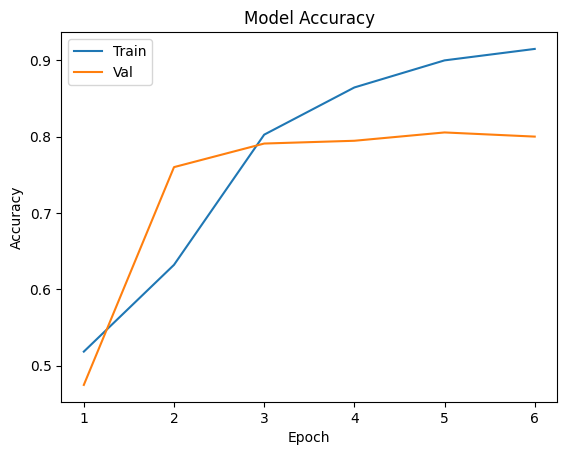

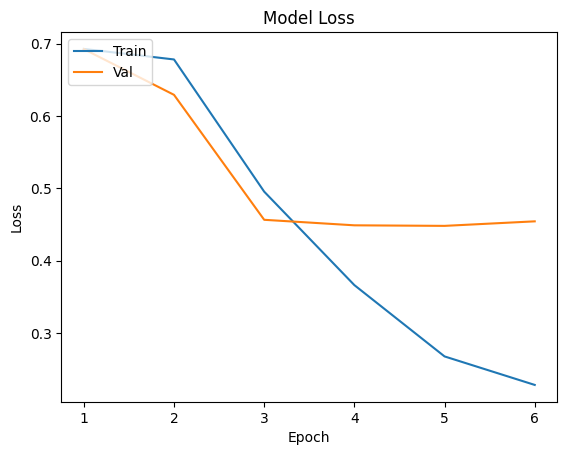

In [128]:
plot_learningCurve(history, 6)

In [129]:
model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8073 - loss: 0.4409 


[0.4543319344520569, 0.800000011920929]

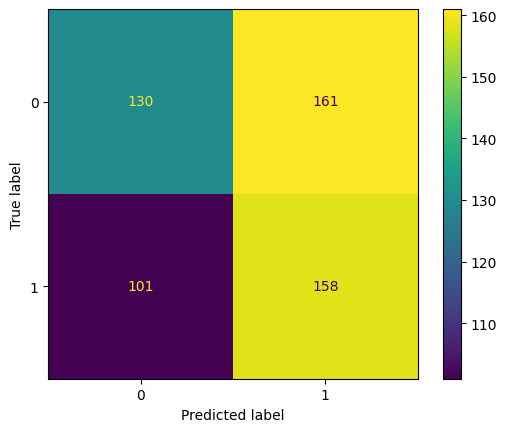

In [130]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = clf.classes_)
disp.plot()
plt.show()

In [133]:
model.save('/content/drive/MyDrive/D213/my_sentiment_model.keras')